# DEA CoastLines validation

To do:
* [X] Change output CRS to Australian Albers
* [X] Discard validation sides with multiple intersects?
* [X] Split analysis code into:
    * Aggregate multiple profiles and export into single file
    * Analyse and plot single file
* [ ] Add extraction of environmental data for each profile line

In [ ]:
# import xarray as xr
# from shapely.geometry import Point, LineString


## Load modules/functions


In [1]:
%matplotlib inline
%load_ext line_profiler
%load_ext autoreload
%autoreload 2

import sys
import glob
import numpy as np
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import box

sys.path.append('/g/data/r78/rt1527/dea-notebooks/MAHTS/')
import deacoastlines_validation as deacl_val
import deacoastlines_statistics as deacl_stats

def to_vector(df, fname='test.shp', x='x', y='y', crs='EPSG:3577'):
    
    # Convert datetimes to strings
    is_datetime = df.dtypes == 'datetime64[ns]'
    df.loc[:, is_datetime] = df.loc[:, is_datetime].astype(str) 
    
    # Export to file
    gpd.GeoDataFrame(data=df.loc[:, df.dtypes != 'datetime64[ns]'],
                     geometry=gpd.points_from_xy(x=df[x], y=df[y]),
                     crs=crs).to_file(fname)

## Analysis
To investigate:
* [X] Outlier in Bermagui (Horseshoe Bay)
* [X] **Multiple outliers in Boambee Beach**
* [X] Single remaining outlier in Bogangar to Kingscliff
* [X] **Cluster of outliers in Burgess Beach: caused by one year of channel profiles**
* [X] Sporadic outliers in Byron Bay
* [X] Two remaining outlier in Corindi Beach
* [X] **Major outliers at Crowdy Head**
* [X] **String of outliers in opposite direction at Cullendulla**
* [X] One remaining outlier at Diamond Beach
* [X] One remaining outlier at Eurobadalla Beaches North
* [ ] **Cluster of outliers at Evans Head and Broadwater**
* [X] Two outliers in Fern Bay
* [ ] **Extreme outliers at Flynn's Beach**
* [ ] **Skewed result at Gerringong Harbour**
* [ ] Outliers in Hargrave's Beach
* [ ] Remaining outliers at Jimmy's Beach
* [X] **Remaining major outlier at Lake Illawarra**
* [X] **Outliers in Manly Beach**
* [X] **Outliers at Mooney Beach**
* [X] **Major issues with offset shorelines at Narrabeen/Collory**
* [X] Outlier at Ocean View Beach
* [X] **Outliers in opposite direction at Park's Beach**
* [X] Cluster of outliers at Patch's Beach
* [X] Outliers at Port Hacking 
* [X] **Weird line of points at Rainbow Beach**
* [X] **No relationship at Sandbar Beach**
* [ ] Outliers at Shellharbour Little Lake
* [X] One remaining outlier at Stuart's Point
* [ ] **Several remaining outliers at Swansea Belmont**
* [X] **Cluster of outliers at The Entrance**
* [X] Single outlier at Warrain
* [ ] **Major issues with Valla Beach**

In [556]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

val_paths = glob.glob('output_data/wadot_*.csv')
deacl_path = '../packages/DEACoastLines_v0.2.0/DEACoastLines_coastlines_v0.2.0.shp'
# deacl_path = '../DEACoastLines_coastlines_v0.2.0_0.20.shp'

stats_list = []

for val_path in val_paths:
    
    # Run analysis and close resulting figure
    print(f'{val_path:<80}', end='\r')
    output_stats = deacl_val.deacl_validation(val_path, 
                                              deacl_path,
                                              datum=0)
    # Close figure if plotting over 10
    if len(stats_list) > 10: plt.close()
    
    # Append stats to list
    stats_list.append(output_stats)
    
# Combine stats into a dataframe
stats_df = pd.concat(stats_list)
stats_df.head()


,id,year,beach,section,profile,source,certainty,n,start_x,start_y,end_x,end_y,val_x,val_y,val_dist,deacl_x,deacl_y,deacl_dist,diff_dist
0,swanbourne_all_0,1990,swanbourne,all,2,photogrammetry,good,1,-1.519258e+06,-3.570231e+06,-1.519631e+06,-3.570086e+06,-1.519418e+06,-3.570169e+06,171.690220,-1.519429e+06,-3.570164e+06,183.532420,-11.842200
1,swanbourne_all_1,1990,swanbourne,all,2,photogrammetry,good,1,-1.521260e+06,-3.564154e+06,-1.521386e+06,-3.564533e+06,-1.521328e+06,-3.564358e+06,214.756983,-1.521326e+06,-3.564354e+06,210.878625,3.878358
2,swanbourne_all_10,1990,swanbourne,all,2,photogrammetry,good,1,-1.519163e+06,-3.570394e+06,-1.519540e+06,-3.570528e+06,-1.519343e+06,-3.570458e+06,191.058209,-1.519348e+06,-3.570460e+06,196.316419,-5.258210
3,swanbourne_all_11,1990,swanbourne,all,2,photogrammetry,good,1,-1.519096e+06,-3.570582e+06,-1.519472e+06,-3.570716e+06,-1.519302e+06,-3.570656e+06,219.292582,-1.519298e+06,-3.570654e+06,214.363724,4.928858
4,swanbourne_all_12,1990,swanbourne,all,2,photogrammetry,good,1,-1.519205e+06,-3.570090e+06,-1.519594e+06,-3.569999e+06,-1.519405e+06,-3.570043e+06,205.778339,-1.519405e+06,-3.570043e+06,205.952880,-0.174541


In [561]:
from shapely.geometry import box, Point, LineString

def export_eval(df, output_name, output_crs='EPSG:3577'):

    # Extract geometries
    val_points = gpd.points_from_xy(x=df.val_x, y=df.val_y)
    deacl_points = gpd.points_from_xy(x=df.deacl_x, y=df.deacl_y)
    df_profiles = df.groupby('id').first()
    profile_lines = df_profiles.apply(
        lambda x: LineString([(x.start_x, x.start_y), (x.end_x, x.end_y)]), axis=1)

    # Export validation points
    val_gdf = gpd.GeoDataFrame(data=df,
                               geometry=val_points,
                               crs=output_crs).to_crs('EPSG:4326')
    val_gdf.to_file(f'figures/eval/{output_name}_val.geojson', driver='GeoJSON')

    # Export DEACL points
    deacl_gdf = gpd.GeoDataFrame(data=df,
                                 geometry=deacl_points,
                                 crs=output_crs).to_crs('EPSG:4326')
    deacl_gdf.to_file(f'figures/eval/{output_name}_deacl.geojson', driver='GeoJSON')

    # Export profiles
    profile_gdf = gpd.GeoDataFrame(data=df_profiles,
                                 geometry=profile_lines,
                                 crs=output_crs).to_crs('EPSG:4326')
    profile_gdf.to_file(f'figures/eval/{output_name}_profiles.geojson', driver='GeoJSON')
    

In [562]:
export_eval(stats_df, output_name)
# stats_df.groupby('beach').apply(lambda x: export_eval(x, x.beach.iloc[0]))

In [597]:
print(f'MAE: {mean_absolute_error(stats_df.val_dist, stats_df.deacl_dist):.2f} m\n'
      f'RMSE: {mean_squared_error(stats_df.val_dist, stats_df.deacl_dist)**0.5:.2f} m\n'
      f'Corr: {stats_df[["val_dist", "deacl_dist"]].corr().iloc[0, 1]:.3f}\n'
      f'Mean offset: {stats_df[["diff_dist"]].mean().iloc[0]:.2f} m\n'
      f'50th perc diff: {stats_df["diff_dist"].abs().quantile(0.50):.2f} m')


MAE: 8.33 m
RMSE: 11.36 m
Corr: 0.976
Mean offset: 4.56 m
50th perc diff: 6.61 m


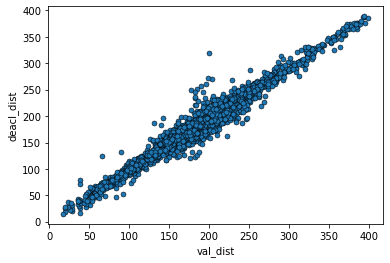

In [575]:
stats_df.plot.scatter(x='val_dist',
                      y='deacl_dist',
#                       c=stats_df.year,
                      s=25,
#                       cmap='YlOrRd',
                      vmin=1987,
                      vmax=2018,
                      edgecolors='black',
                      linewidth=0.5)

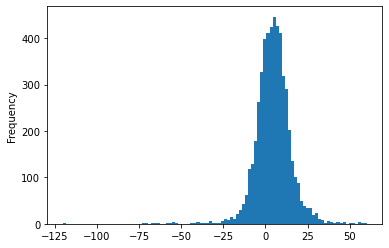

In [592]:
stats_df.diff_dist.plot.hist(bins=100)

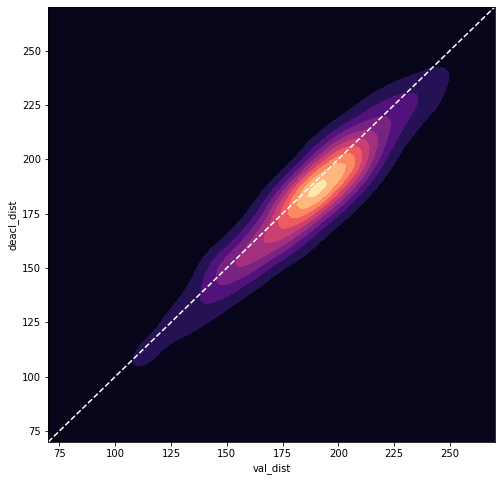

In [583]:
import seaborn as sns

extent = (70, 270)

fig, ax = plt.subplots(figsize=(8, 8))
sns.kdeplot(ax=ax,
            data=stats_df.val_dist,
            data2=stats_df.deacl_dist, 
            cmap='magma', 
            shade=True,
#             shade_lowest=False,
            clip=(extent, extent)
           )
plt.gca().plot(np.linspace(*extent), 
               np.linspace(*extent),
               color='white',
               linestyle='dashed')

In [585]:
stats_df.groupby('beach')['diff_dist'].mean()

beach
binningup                                   -0.499022
bussleton                                    7.452548
capebouvard                                  1.131666
capelrivermouth                              2.062693
capenaturaliste                             10.491268
capeperon                                   -0.002389
challengerbeach                              0.606451
guilderton                                   9.783573
pinnaroopoint                               12.891125
pointcasuarina                              -0.177246
pointdaking                                 10.922081
quinnsrocks                                 13.299416
robertpoint                                  0.740145
rottnestisland,carnacisland,gardenisland     1.816183
roushead                                     9.869428
swanbourne                                  10.980073
wreckpoint                                  10.724270
Name: diff_dist, dtype: float64

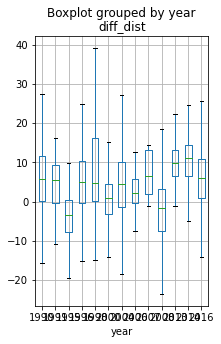

In [587]:
stats_df.boxplot(column='diff_dist', by='year', figsize=(3, 5), showfliers=False)

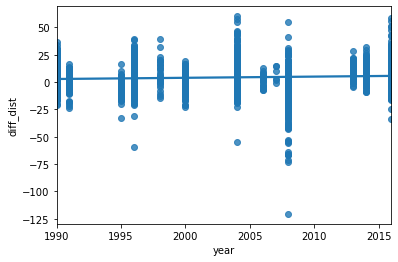

In [588]:
sns.regplot(x='year', y='diff_dist', data=stats_df)

In [745]:
to_vector(output_stats, fname='test6.shp', x='0_x', y='0_y', crs='EPSG:3577')

## Pre-processing


### Victoria/Deakin
* [X] Renovated

In [ ]:
deacl_val.preprocess_vicdeakin(fname='input_data/vicdeakin/z_data_10cm_VIC.csv',
                               datum=0)

### WRL Narrabeen 
* [X] Renovated

In [ ]:
deacl_val.preprocess_narrabeen(fname='input_data/wrl/Narrabeen_Profiles_2018.csv',
                               datum=0,
                               overwrite=True)


### NSW Beach Profile Database
* [X] Renovated

In [143]:
for fname in glob.glob('input_data/nswbpd/*.csv'):
    profiles_df = deacl_val.preprocess_nswbpd(fname, 
                                              datum=0, 
                                              overwrite=True)     


/g/data/v10/public/modules/dea-env/20200526/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3254: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):



Dropping invalid profiles: 19                                                                              
Processing output_data/nswbpd_brunswick.csv                                                
Dropping invalid profiles: 1                                                                               
Processing output_data/nswbpd_saphirebeach.csv                                             
Dropping invalid profiles: 13                                                                              
Processing output_data/nswbpd_ballina.csv                                                  
Dropping invalid profiles: 1                                                                               
Processing output_data/nswbpd_boambeebeach.csv                                             
Dropping invalid profiles: 9                                                                               
Processing output_data/nswbpd_saltsbay.csv                                                 

In [142]:
glob.glob('input_data/nswbpd/*.csv')
# fname = 'input_data/nswbpd/photogrammetry_Xsections_The Entrance.csv'
# fname = 'input_data/nswbpd/photogrammetry_Xsections_Booti Booti.csv'
# fname = 'input_data/nswbpd/photogrammetry_Xsections_Tweed Entrance Breakwaters.csv'
# fname = 'input_data/nswbpd/photogrammetry_Xsections_Port Hacking, Cornulla and Kurnell.csv'
# fname = 'input_data/nswbpd/photogrammetry_Xsections_Jimmys Beach.csv'

['input_data/nswbpd/photogrammetry_Xsections_Port Macquarie.csv',
 'input_data/nswbpd/photogrammetry_Xsections_Hungry Head and Repton.csv',
 'input_data/nswbpd/photogrammetry_Xsections_Cresent Head.csv',
 'input_data/nswbpd/photogrammetry_Xsections_Corindi to Red Rock.csv',
 'input_data/nswbpd/photogrammetry_Xsections_Lennox Head.csv',
 'input_data/nswbpd/photogrammetry_Xsections_South West Rocks.csv',
 'input_data/nswbpd/photogrammetry_Xsections_Hearns Lake and Back Beach.csv',
 'input_data/nswbpd/photogrammetry_Xsections_Tuncurry and Failford.csv',
 'input_data/nswbpd/photogrammetry_Xsections_Brunswick.csv',
 'input_data/nswbpd/photogrammetry_Xsections_Boambee North.csv',
 'input_data/nswbpd/photogrammetry_Xsections_Fern Bay.csv',
 'input_data/nswbpd/photogrammetry_Xsections_Farquar Inlet to Harrington.csv',
 'input_data/nswbpd/photogrammetry_Xsections_Saphire Beach.csv',
 'input_data/nswbpd/photogrammetry_Xsections_Broulee Beach .csv',
 'input_data/nswbpd/photogrammetry_Xsections_Ev

In [141]:
profiles_df = deacl_val.preprocess_nswbpd(fname, 
                                          datum=0, 
                                          overwrite=True)    

In [134]:
profiles_df

,beach,section,profile,date,distance,z,x,y,source,id,start_x,start_y,end_x,end_y


In [105]:
foredune_dist = profiles_df.groupby(['id', 'date']).apply(
    lambda x: x.distance.loc[x.z.idxmax()]).reset_index(name='foredune_dist')
profiles_df = pd.merge(left=profiles_df, right=foredune_dist) 
profiles_df = profiles_df.loc[(profiles_df.distance >= 
                               profiles_df.foredune_dist)]


In [136]:
foredune_dist = profiles_df.groupby(['id', 'date']).apply(
            lambda x: x.distance.loc[x.z.idxmax()])
.reset_index(name='foredune_dist')

TypeError: reset_index() got an unexpected keyword argument 'name'

In [138]:
foredune_dist.name = 'hello'

In [140]:
profiles_df = pd.merge(left=profiles_df, right=foredune_dist) 
profiles_df = profiles_df.loc[(profiles_df.distance >= 
                               profiles_df.foredune_dist)]

MergeError: No common columns to perform merge on. Merge options: left_on=None, right_on=None, left_index=False, right_index=False

In [76]:
profiles_df.distance.loc[test]

7.0        97.342
7.0        97.342
7.0        97.342
7.0        97.342
7.0        97.342
            ...  
34801.0    66.237
34801.0    66.237
34801.0    66.237
34801.0    66.237
34801.0    66.237
Name: distance, Length: 28157, dtype: float64

In [17]:
after_foredune = lambda x: x[x.distance >= x.distance.loc[x.z.idxmax()]]
profiles_df = (profiles_df.groupby(['id', 'date'])
               .apply(after_foredune)
               .reset_index(drop=True))   
        

In [27]:
after_foredune = lambda x: x.distance.loc[x.z.idxmax()]

In [32]:
test.z.idxmax()

15595

In [37]:
to_vector(test, fname='test6.shp', x='x', y='y', crs='EPSG:3577')

In [64]:
for id_var in profiles_df.id.unique():
    test = profiles_df.loc[(profiles_df.id == id_var) ]
    print(id_var, test[['x', 'y']].corr().abs().iloc[0, 1])
    # test.plot(x='x', y='y', figsize=(10, 5))

parksbeach_4n_1 0.9999870671625477
parksbeach_4n_2 0.9999831792738936
parksbeach_4n_3 0.9999843443742671
parksbeach_4n_4 0.9999805569482376
parksbeach_4n_5 0.9999792403715323
parksbeach_4n_6 0.9999780817412312
parksbeach_4s_1 0.9999995021881485
parksbeach_4s_2 0.9999994051000238
parksbeach_5n_1 0.9999940974463946
parksbeach_5n_2 0.9999941943990835
parksbeach_5n_3 0.9999946312088894
parksbeach_5n_4 0.9999951454515699
parksbeach_5n_5 0.9999957742040945
parksbeach_5n_6 0.9999944954805143
parksbeach_5n_7 0.9999955489013144
parksbeach_5n_8 0.9999715662974179
parksbeach_5n_9 0.9999913034350315
parksbeach_5n_10 0.9999885032420782
parksbeach_5n_11 0.9999321275313309
parksbeach_5n_12 0.9999945824657207
parksbeach_5s_1 0.9826456439303526
parksbeach_5s_2 0.9851913245699951
parksbeach_5s_3 0.9842135645909544
parksbeach_5s_4 0.9805595893024284
parksbeach_5s_5 0.976032049151572
parksbeach_5s_6 0.9812462624907385
parksbeach_5s_7 0.9987404304916732
parksbeach_5s_8 0.9986130753563565
parksbeach_5s_9 0.

parksbeach_5s_12 0.9999999945174645


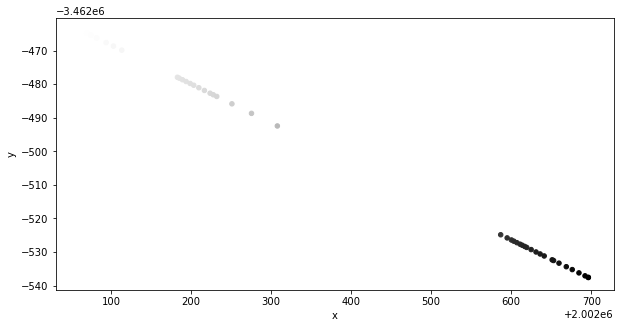

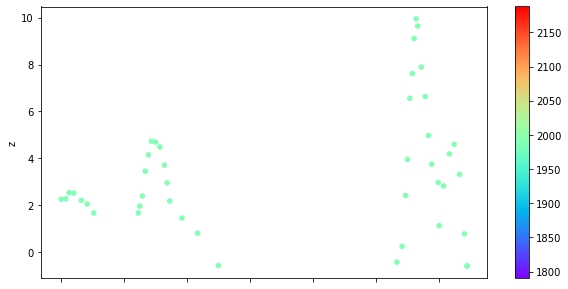

In [66]:
test = profiles_df.loc[(profiles_df.id == 'parksbeach_4s_1') ]
test = test.loc[(profiles_df.date.dt.year == 1989)]
print(id_var, test[['x', 'y']].corr().abs().iloc[0, 1])
test.plot.scatter(x='x', y='y', figsize=(10, 5), c=test.distance)
test.plot.scatter(x='distance', y='z', figsize=(10, 5), c=test.date.dt.year, cmap='rainbow')

jimmysbeach_5_24 0.9999999687274194


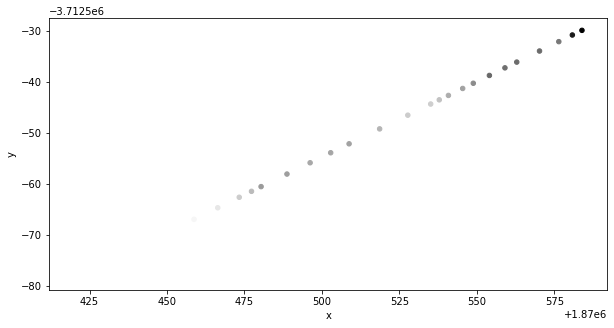

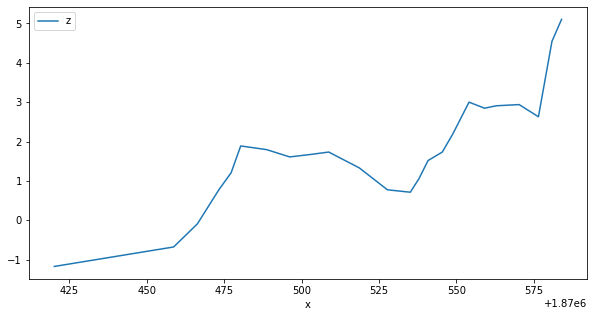

In [18]:
test = profiles_df.loc[(profiles_df.id == 'jimmysbeach_1_11') ]
test = test.loc[(profiles_df.date.dt.year == 1994)]
print(id_var, test[['x', 'y']].corr().abs().iloc[0, 1])
test.plot.scatter(x='x', y='y', figsize=(10, 5), c=test.z)
test.plot(x='x', y='z', figsize=(10, 5))

In [664]:
test = profiles_df.loc[(profiles_df.id == 'porthacking,cornullaandkurnell_6_1') ]

In [ ]:
valid_profiles(test)

In [558]:
test = profiles_df.loc[(profiles_df.id == 'theentrance_f_27') & (profiles_df.date.dt.year == 2016)]

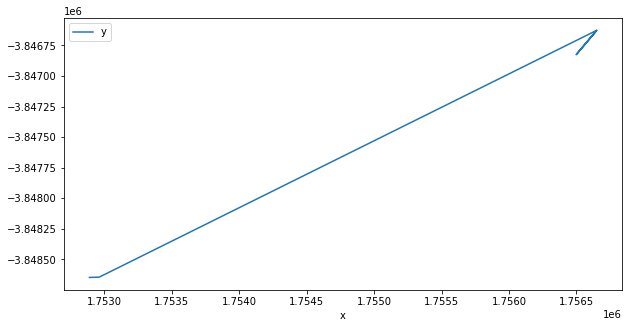

In [630]:
test.plot(x='x', y='y', figsize=(10, 5))

In [631]:
from sklearn.metrics import mean_squared_error

In [667]:
# valid_profiles = lambda x: mean_squared_error(x.x, x.y) ** 0.5  # < 50
# drop = (~profiles_df.groupby('id').apply(valid_profiles)).sum()
valid_profiles = lambda x: x[['x', 'y']].corr().abs().iloc[0, 1] 
test2 = profiles_df.groupby('id').apply(valid_profiles)        
# if drop.sum() > 0: print(f'\nDropping invalid profiles: {drop:<80}')

In [668]:
test2 

id
porthacking,cornullaandkurnell_0_1     0.999998
porthacking,cornullaandkurnell_0_10    0.999997
porthacking,cornullaandkurnell_0_11    0.999995
porthacking,cornullaandkurnell_0_12    0.999995
porthacking,cornullaandkurnell_0_2     0.999997
                                         ...   
porthacking,cornullaandkurnell_9_5     0.999995
porthacking,cornullaandkurnell_9_6     0.999995
porthacking,cornullaandkurnell_9_7     0.999988
porthacking,cornullaandkurnell_9_8     0.999981
porthacking,cornullaandkurnell_9_9     0.999993
Length: 235, dtype: float64

In [641]:
test2.min()

5601097.35611594

In [571]:
after_foredune = lambda x: x.distance.values >= x.distance.loc[x.z.idxmax()]
profiles_df.groupby(['id', 'date']).filter(after_foredune)

TypeError: filter function returned a ndarray, but expected a scalar bool

In [548]:
# test = profiles_df.loc[(profiles_df.id == 'byronbay_c_2') & (profiles_df.date.dt.year == 2012)]  #.plot.scatter(x='x', y='z')

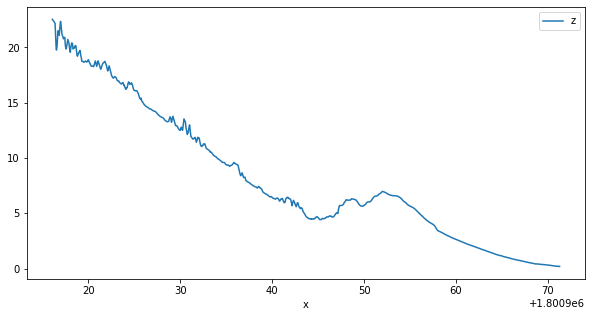

In [559]:
test.plot(x='x', y='z', figsize=(10, 5))


In [498]:
# profiles_df.loc[profiles_df['0_dist'] > profiles_df['foredune_dist']]

In [515]:
# profiles_df


nan

In [500]:
# foredune_dist.name = 'test'

In [522]:
deacl_val.waterline_intercept(test, z_val=0)

78.76812499999998 281.19960000000003
Sad!


0_dist   NaN
0_x      NaN
0_y      NaN
dtype: float64

In [505]:
x=test 
dist_col='distance'
x_col='x'
y_col='y'
z_col='z'
z_val=0
    
deacl_val.interp_intercept(x[dist_col].values, x[z_col].values, z_val, reverse=True)

255.14600000000002

In [623]:
to_vector(profiles_df, fname='test5.shp', x='x', y='y', crs='EPSG:3577')

### City of Gold Coast
* [X] Renovated

In [ ]:
# List of sites to iterate over
all_profiles = glob.glob(f'input_data/cityofgoldcoast/*.txt')
sites = np.unique([i.split(' - ')[0].split('/')[-1] for i in all_profiles])
sites = ['SOUTH STRADBROKE']

for site in sites:
    deacl_val.preprocess_cgc(site=site, 
                             datum=0,
                             overwrite=True)

### TASMARC
* [X] Renovated

In [ ]:
# List of sites to iterate over
sites = [i.split('/')[2] for i in glob.glob('input_data/tasmarc/*/')]

for site in sites[3:4]:
    deacl_val.preprocess_tasmarc(site, overwrite=True) 


### WA DoT
* [X] Renovated

In [554]:
# Read in tertiary compartment file to regionalise results
# tertiary_gdf = gpd.read_file('input_data/WA_tertiaryCC.shp').to_crs('EPSG:3577')
tertiary_gdf = gpd.read_file('input_data/wa_sw.geojson').to_crs('EPSG:3577')
tertiary_gdf = tertiary_gdf.set_index('FROM_')

# Extract transects and validation distances
deacl_val.preprocess_wadot(regions_gdf=tertiary_gdf, 
                           fname='input_data/wadot/Coastline_Movements_20190819.gdb',
                           smartline='../input_data/Smartline.gdb',
                           aus_poly='/g/data/r78/rt1527/shapefiles/australia/australia/cstauscd_r.shp')

### SA Department of Environment and Water

In [ ]:
import math
from pyproj import Transformer

# Load data and set nodata values to NaN
wide_df = pd.read_csv('input_data/sadew/200011.CSV', na_values=[-9999])

# Reproject coords to Albers and create geodataframe
trans = Transformer.from_crs("EPSG:28354", "EPSG:28356", always_xy=True)
wide_df['EASTING'], wide_df['NORTHING'] = trans.transform(
    wide_df.EASTING.values, wide_df.NORTHING.values)

# Reshape into long format with each observation on a new row
profile_df = pd.melt(wide_df.drop('SAMPLE_NO', axis=1), 
                     id_vars=['EASTING', 'NORTHING', 'PROFILE'],
                     value_name='elevation').dropna()

# Set column names to lower case
profile_df.columns = profile_df.columns.str.lower()

# Extract date info
profile_df['date'] = profile_df['variable'].str[1:].str.strip()
profile_df['date'] = pd.to_datetime(profile_df['date'], format='%d%m%Y')

# Restrict to post 1987
profile_df = profile_df[(profile_df.date.dt.year > 1987)]

# Add unique ID column
profile_df['beach'] = 'sadew'
profile_df['section'] = 'all'
profile_df['profile'] = profile_df['profile'].astype(str)
profile_df['site'] = profile_df[['beach', 'section', 'profile']].apply('_'.join, 1)
profile_df['source'] = 'sadew'

# Compute origin points for each profile
profile_df = profile_df.assign(start_x=wide_df.iloc[0, 2], 
                               start_y=wide_df.iloc[0, 3],
                               end_x=wide_df.iloc[-1, 2],
                               end_y=wide_df.iloc[-1, 3])

# Compute chainage
profile_df['chainage'] = profile_df.apply(
    lambda x: math.hypot(x.easting - x.start_x, x.northing - x.start_y), axis=1)

In [ ]:
# Find location and distance to water for datum height (0 m AHD)
out = profile_df.groupby(['site', 'date']).apply(deacl_val.waterline_intercept, 
                                                  dist_col='chainage',
                                                  x_col='easting', 
                                                  y_col='northing', 
                                                  z_col='elevation', 
                                                  z_val=0).dropna()

# If the output contains data
if len(out.index):

    # Join into dataframe
    shoreline_dist = out.join(
        profile_df.groupby(['site', 'date']).first())

    # Keep required columns
    shoreline_dist = shoreline_dist[['beach', 'section', 'profile',  
                                     'source', 'start_x', 'start_y', 
                                     'end_x', 'end_y', '0_dist', 
                                     '0_x', '0_y']]

    # Export to file
    shoreline_dist.to_csv(f'output_data/satest.csv')

## Testing NSWBPD

In [ ]:
fname = 'input_data/nswbpd/photogrammetry_Xsections_Burril Lake and Racecourse Beach.csv'

# Get output filename
name = Path(fname).stem.split('_')[-1].lower().replace(' ', '')
fname_out = f'output_data/nswbpd_{name}.csv'

# Read in data
print(f'Processing {fname_out}             ', end='\r')            
profiles_df = pd.read_csv(fname, skiprows=5)
profiles_df['Year/Date'] = pd.to_datetime(profiles_df['Year/Date'],
                                          dayfirst=True,
                                          errors='coerce')

# Restrict to post 1987
profiles_df = profiles_df[profiles_df['Year/Date'] > '1987']

# Convert columns to strings and add unique ID column
profiles_df['Beach'] = profiles_df['Beach'].str.lower().str.replace(' ', '')
profiles_df['Block'] = profiles_df['Block'].astype(str).str.lower()
profiles_df['Profile'] = profiles_df['Profile'].astype(str).str.lower()
profiles_df['site'] = profiles_df[['Beach', 'Block',
                                   'Profile']].apply('_'.join, 1)

# Rename columns
profiles_df.columns = ['beach', 'section', 'profile', 'date', 'chainage', 
                       'elevation', 'easting', 'northing', 'source', 'site']

# # Compute origin points for each profile
# start_xy = profiles_df.loc[profiles_df.groupby(['site']).chainage.idxmin(), 
#                             ['site', 'easting', 'northing']]
# start_xy = start_xy.rename({'easting': 'start_x', 
#                             'northing': 'start_y'}, axis=1)
# start_xy = start_xy.reset_index(drop=True)

# # Compute end points for each profile
# end_xy = profiles_df.loc[profiles_df.groupby(['site']).chainage.idxmax(), 
#                          ['site', 'easting', 'northing']]
# end_xy = end_xy.rename({'easting': 'end_x', 
#                         'northing': 'end_y'}, axis=1)
# end_xy = end_xy.reset_index(drop=True)

# # Join origin and end points into dataframe
# profiles_df = pd.merge(left=profiles_df, right=start_xy)
# profiles_df = pd.merge(left=profiles_df, right=end_xy)

# # Find location and distance to water for datum height (0 m AHD)
# out = profiles_df.groupby(['site', 'date']).apply(deacl_val.waterline_intercept, 
#                                                   dist_col='chainage',
#                                                   x_col='easting', 
#                                                   y_col='northing', 
#                                                   z_col='elevation', 
#                                                   z_val=0).dropna()

In [ ]:
profiles_sub = profiles_df[(profiles_df.site == 'burrillakeandracecoursebeach_1_5') & (profiles_df.date == '1993-05-14') ]  

In [ ]:
burrillakeandracecoursebeach_1_5

In [ ]:
to_vector(profiles_df, x='easting', y='northing', fname='test6.shp')

## Testing GCC

In [ ]:
results_df


results_df[(results_df.site == 'broadbeach_eta_59') ]

In [ ]:
pd.read_csv(val_paths[0], parse_dates=['date'], index_col='site').loc['broadbeach_eta_58.50']

In [ ]:
 x.geometry_val.intersection(x.geometry_deacl)
            .hausdorff_distance(Point(x.start_x, x.start_y)), axis=1)


In [ ]:
gpd.GeoSeries(results_df.loc[results_df.site == 'broadbeach_eta_59'].iloc[0].geometry_val).plot()


gpd.GeoSeries(results_df.loc[results_df.site == 'broadbeach_eta_59'].iloc[0].geometry_val.interpolate(219)).plot(ax=plt.gca())

In [ ]:
results_df.loc[results_df.site == 'broadbeach_eta_59'].iloc[0].geometry_val.length

In [ ]:
profile_i = '/g/data/r78/rt1527/dea-notebooks/MAHTS/validation/input_data/cityofgoldcoast/BROADBEACH - ETA 59 - (13474) 1996-06-05.txt'


pd.read_csv(profile_i,
                                 usecols=[1, 2, 3],
                                 delim_whitespace=True, 
                                 names=['x', 'y', 'z']).plot.scatter(x='x', y='z')

In [ ]:
profile_list 

In [ ]:
profile_list = glob.glob(f'input_data/cityofgoldcoast/SOUTH STRADBROKE - SSI 09 *.txt')

# Output list to hold data
site_profiles = []

for profile_i in profile_list:

    # Identify unique field values from file string
    profile_string = os.path.basename(profile_i)

    # Treat data file string differently depending on format
    if len(profile_string.split(' - ')) > 3:
        beach, section, profile, id_date = profile_string.split(' - ')            

    else:
        beach, section_profile, id_date = profile_string.split(' - ')

        if len(section_profile.split(' ')) == 2:
            section, profile = section_profile.split(' ')

        else:
            section, profile = 'none', section_profile

    # If beach name is in the list of problematic names, replace
    beach = manual_rename[beach] if beach in manual_rename.keys() else beach

    # Remove any special characters from beach/section/profile names and create ID 
    profile_df = pd.read_csv(profile_i,
                             usecols=[1, 2, 3],
                             delim_whitespace=True, 
                             names=['x', 'y', 'z'])
    profile_df['date'] = pd.to_datetime(id_date[-14:-4]) 
    profile_df['source'] = 'hydrographic survey'
    profile_df['profile'] = profile.lower()
    profile_df['section'] = section.lower()
    profile_df['beach'] = beach.replace(' ', '').lower()
    profile_df['site'] = profile_df[['beach', 'section', 'profile']].apply('_'.join, 1)

    # Filter to drop pre-1987 and deep water samples, add to list if any 
    # data is available above 0 MSL
    profile_df = profile_df[profile_df.z > -3.0]
    profile_df = profile_df[profile_df.date > '1987']    
    if profile_df.z.max() > 0:
        site_profiles.append(profile_df)

# Combine into a single dataframe
profiles_df = pd.concat(site_profiles)

# Compute origin and end points for each profile
start_xy = profiles_df.groupby(['site'], as_index=False).first()[['site', 'x', 'y']]
end_xy = profiles_df.groupby(['site'], as_index=False).last()[['site', 'x', 'y']]
start_xy = start_xy.rename({'x': 'start_x', 'y': 'start_y'}, axis=1)
end_xy = end_xy.rename({'x': 'end_x', 'y': 'end_y'}, axis=1)

# Join origin and end points into dataframe
profiles_df = pd.merge(left=profiles_df, right=start_xy)
profiles_df = pd.merge(left=profiles_df, right=end_xy)

# # Compute chainage
# profiles_df['chainage'] = profiles_df.apply(
#     lambda x: math.hypot(x.x - x.start_x, x.y - x.start_y), axis = 1)

# # Find location and distance to water for datum height (0 m AHD)
# out = profiles_df.groupby(['site', 'date']).apply(deacl_val.waterline_intercept, 
#                                                   dist_col='chainage',
#                                                   x_col='x', 
#                                                   y_col='y', 
#                                                   z_col='z', 
#                                                   z_val=0).dropna()

In [ ]:
profiles_subset = profiles_df.loc[profiles_df.date.dt.year == 2013]
profiles_subset.plot(x='x', y='z')

In [ ]:
to_vector(profiles_df.loc[profiles_df.date.dt.year == 2013], fname='test4.shp')



    

In [ ]:
merge_test.groupby('year').median().reset_index().plot(x='year', y='DEA CoastLines beach width (m)')
merge_test.groupby('year').median().reset_index().plot(x='year', y='Validation beach width (m)', ax=plt.gca())

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** May 2020